# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Load The Dataset

## Load Train Data

In [2]:
trainData = pd.read_csv("input/train.csv")

print("Train Dataset shape:", trainData.shape)

print("\nTrain Dataset Info:\n")
trainData.info()

print("\nFirst 5 Rows of the Dataset:\n")
trainData.head()

Train Dataset shape: (1642, 10)

Train Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1642 non-null   object 
 1   year          1642 non-null   int64  
 2   motor_type    1642 non-null   object 
 3   running       1642 non-null   object 
 4   wheel         1642 non-null   object 
 5   color         1642 non-null   object 
 6   type          1642 non-null   object 
 7   status        1642 non-null   object 
 8   motor_volume  1642 non-null   float64
 9   price         1642 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 128.4+ KB

First 5 Rows of the Dataset:



,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000


## Load Test Data

In [3]:
testData = pd.read_csv("input/test.csv")

print("Test Dataset shape:", testData.shape)

print("\nTest Dataset Info:\n")
testData.info()

print("\nFirst 5 Rows of the Test Dataset:\n")
testData.head()

Test Dataset shape: (411, 10)

Test Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            411 non-null    int64  
 1   model         411 non-null    object 
 2   year          411 non-null    int64  
 3   motor_type    411 non-null    object 
 4   running       411 non-null    object 
 5   wheel         411 non-null    object 
 6   color         411 non-null    object 
 7   type          411 non-null    object 
 8   status        411 non-null    object 
 9   motor_volume  411 non-null    float64
dtypes: float64(1), int64(2), object(7)
memory usage: 32.2+ KB

First 5 Rows of the Test Dataset:



,Id,model,year,motor_type,running,wheel,color,type,status,motor_volume
0,0,kia,2020,petrol,24000 km,left,black,sedan,excellent,2.0
1,1,nissan,2017,petrol,85000 miles,left,white,suv,excellent,2.0
2,2,hyundai,2021,petrol,30000 miles,left,white,sedan,excellent,2.0
3,3,kia,2018,petrol,53000 miles,left,silver,sedan,excellent,2.0
4,4,mercedes-benz,2003,petrol,230000 km,left,black,Universal,normal,1.8


# Data Preprocessing

## Check for missing values in Train Dataset

In [4]:
missing_values = trainData.isnull().sum()
missing_percentage = (missing_values / len(trainData)) * 100

missing_df = pd.DataFrame({"Missing Count": missing_values, "Missing %": missing_percentage})
missing_df = missing_df[missing_df["Missing Count"] > 0]

# Display results
if missing_df.empty:
    print("No Missing Values in Train Dataset!")
else:
    print("Missing Values Found in Train Dataset:\n")
    print(missing_df.sort_values(by="Missing %", ascending=False))


No Missing Values in Train Dataset!


## Handle numerical missing values (in-case if any in future)

In [5]:
numerical_columns = trainData.select_dtypes(include=['int64', 'float64']).columns

# Fill missing values with median
trainData[numerical_columns] = trainData[numerical_columns].apply(lambda col: col.fillna(col.median()))

missing_numerical = trainData[numerical_columns].isnull().sum()

if missing_numerical.sum() == 0:
    print("No missing values remain in numerical columns!")
else:
    print("Some numerical columns still have missing values:\n", missing_numerical)

No missing values remain in numerical columns!


## Handle categorical missing values (in-case if any in future)

In [6]:
categorical_columns = trainData.select_dtypes(include=['object']).columns

# Fill missing values with most frequent value
trainData[categorical_columns] = trainData[categorical_columns].apply(lambda col: col.fillna(col.mode()[0]))

missing_categorical = trainData[categorical_columns].isnull().sum()

if missing_categorical.sum() == 0:
    print("No missing values remain in categorical columns!")
else:
    print("Some categorical columns still have missing values:\n", missing_categorical)

No missing values remain in categorical columns!


## Convert Units in Train Dataset

In [7]:
# Function to clean and convert running column
def convert_running(value):
    value = value.lower().replace(",", "").strip()
    if "miles" in value:
        num = float(value.replace("miles", "").strip()) * 1.60934  # Convert miles to km
    elif "km" in value:
        num = float(value.replace("km", "").strip())
    else:
        num = np.nan
    return num

# Apply conversion function to running column
trainData["running_km"] = trainData["running"].apply(convert_running)

trainData.drop(columns=["running"], inplace=True)

# Display the cleaned column
trainData[["running_km"]].head()

,running_km
0,3000.00
1,132000.00
2,152887.30
3,220479.58
4,130000.00



## Convert Units in Test Dataset

In [8]:
testData["running_km"] = testData["running"].apply(convert_running)
testData.drop(columns=["running"], inplace=True)
testData[["running_km"]].head()

,running_km
0,24000.00
1,136793.90
2,48280.20
3,85295.02
4,230000.00


## Encode categorical variables

In [9]:
# List of categorical columns
categorical_columns = ["model", "motor_type", "wheel", "color", "type", "status"]

# Apply One-Hot Encoding for categorical features
train_encoded = pd.get_dummies(trainData, columns=categorical_columns, drop_first=True)
test_encoded = pd.get_dummies(testData, columns=categorical_columns, drop_first=True)

# Align columns to ensure both datasets have the same features
train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

train_encoded.info()
train_encoded.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       1642 non-null   int64  
 1   motor_volume               1642 non-null   float64
 2   price                      1642 non-null   int64  
 3   running_km                 1642 non-null   float64
 4   model_kia                  1642 non-null   bool   
 5   model_mercedes-benz        1642 non-null   bool   
 6   model_nissan               1642 non-null   bool   
 7   model_toyota               1642 non-null   bool   
 8   motor_type_gas             1642 non-null   bool   
 9   motor_type_hybrid          1642 non-null   bool   
 10  motor_type_petrol          1642 non-null   bool   
 11  motor_type_petrol and gas  1642 non-null   bool   
 12  color_black                1642 non-null   bool   
 13  color_blue                 1642 non-null   bool 

,year,motor_volume,price,running_km,model_kia,model_mercedes-benz,model_nissan,model_toyota,motor_type_gas,motor_type_hybrid,...,type_Universal,type_hatchback,type_minivan / minibus,type_pickup,type_sedan,type_suv,status_excellent,status_good,status_new,status_normal
0,2022,2.0,24500,3000.00,False,False,False,True,False,False,...,False,False,False,False,True,False,True,False,False,False
1,2014,2.0,25500,132000.00,False,True,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
2,2018,2.0,11700,152887.30,True,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
3,2002,3.2,12000,220479.58,False,True,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
4,2017,2.0,26000,130000.00,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False


# Exploratory Data Analysis (EDA) On Train Dataset

1642 rows, 10 columns

**Target variable** - price

**Feature Columns:**

Categorical: model, motor_type, running, wheel, color, type, status

Numerical: year, motor_volume

In [10]:
print()

## Distribution of the Target Variable

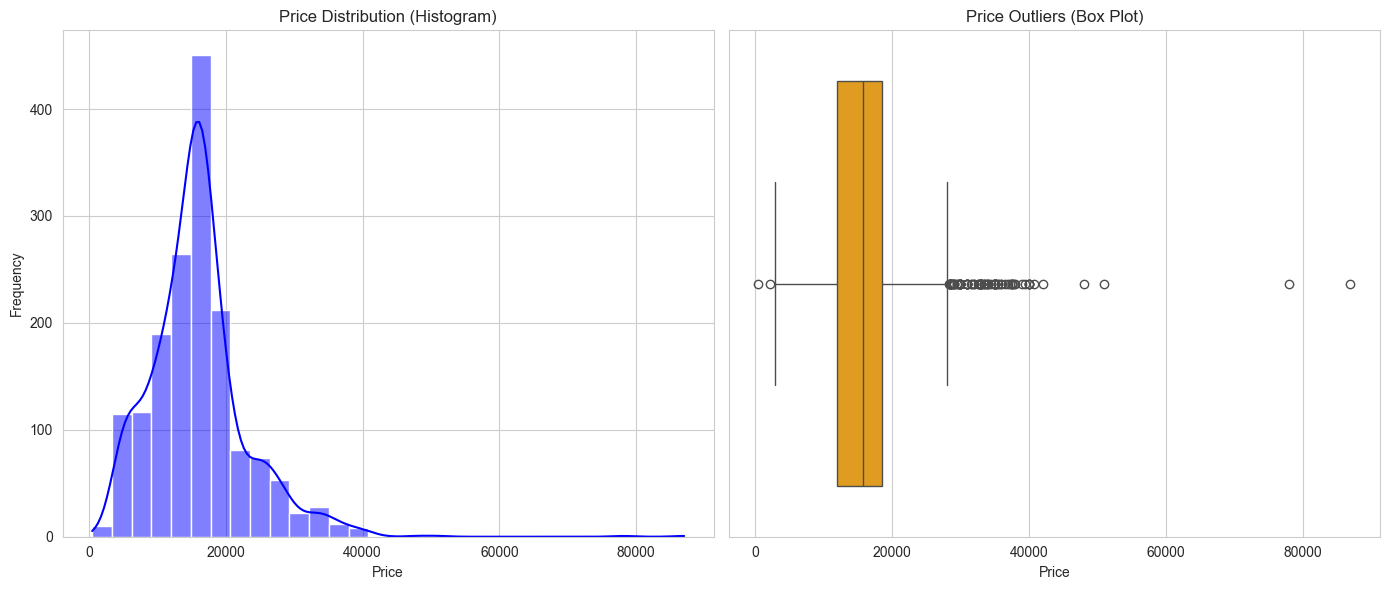

In [11]:
plt.figure(figsize=(14, 6))

# Histogram for Price Distribution
plt.subplot(1, 2, 1)
sns.histplot(trainData["price"], bins=30, kde=True, color="blue")
plt.title("Price Distribution (Histogram)")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Boxplot for Identifying Outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=trainData["price"], color="orange")
plt.title("Price Outliers (Box Plot)")
plt.xlabel("Price")

# Show Plots
plt.tight_layout()
plt.show()



### Histogram Analysis
##### The histogram shows a right-skewed distribution, meaning that most car prices are lower, but there are some cars with very high prices.
##### This suggests that a log transformation could help normalize the distribution, making it easier for the model to learn.

### Box Plot Analysis
##### The box plot clearly shows extreme outliers at the higher end of the price range.
##### These high prices could negatively impact model performance, as Random Forest models are affected by extreme values.

## Feature-Target Relationship

### Year vs Price

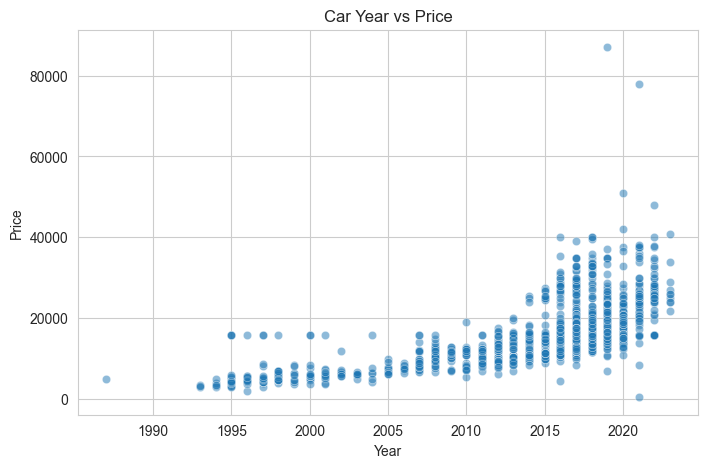

In [12]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=trainData["year"], y=trainData["price"], alpha=0.5)
plt.title("Car Year vs Price")
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

### Type vs Price

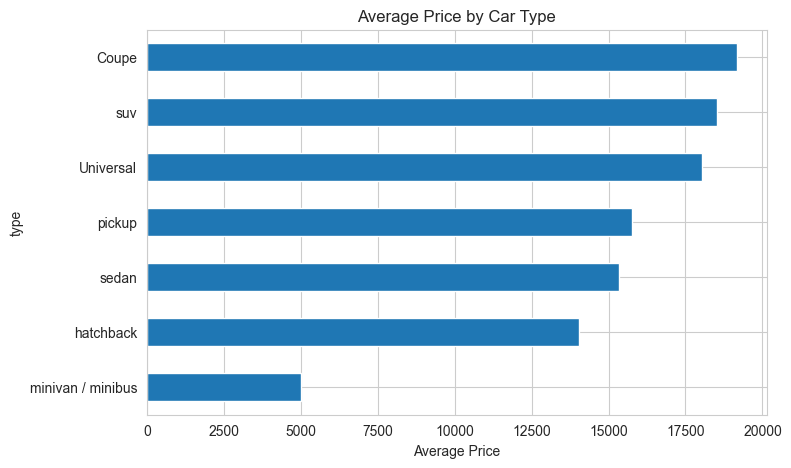

In [13]:
types = trainData.groupby("type")["price"].mean().sort_values()

types.plot(kind="barh", figsize=(8, 5), title="Average Price by Car Type")
plt.xlabel("Average Price")
plt.show()

### Moto volume vs Price

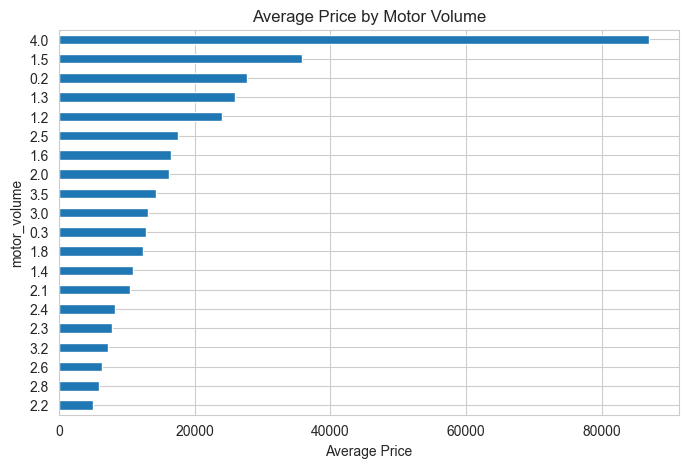

In [14]:
types = trainData.groupby("motor_volume")["price"].mean().sort_values()

types.plot(kind="barh", figsize=(8, 5), title="Average Price by Motor Volume")
plt.xlabel("Average Price")
plt.show()

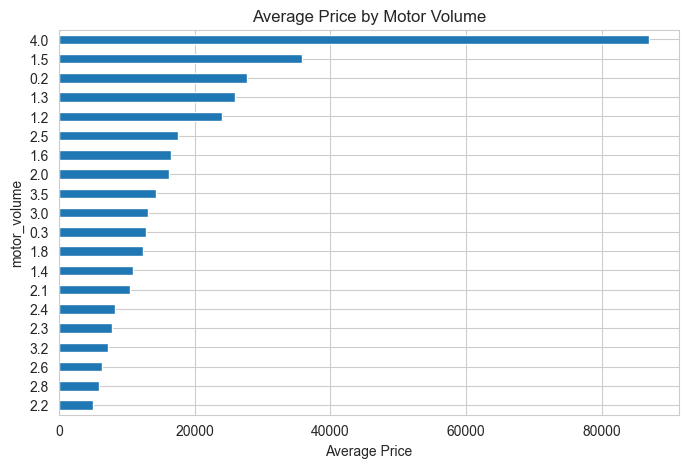

In [15]:
types = trainData.groupby("motor_volume")["price"].mean().sort_values()

types.plot(kind="barh", figsize=(8, 5), title="Average Price by Motor Volume")
plt.xlabel("Average Price")
plt.show()

## Feature Relationships (Numerical Features)

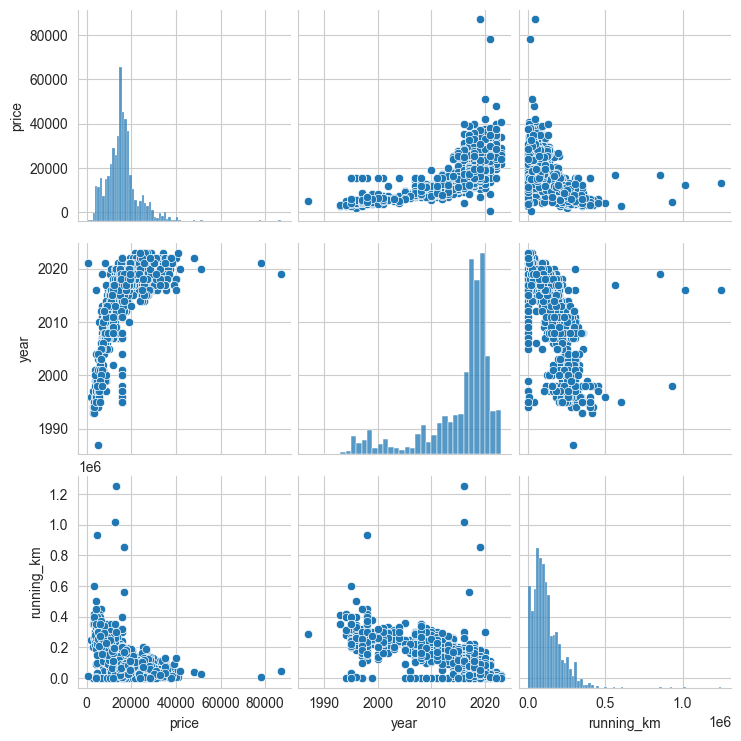

In [16]:
selected_features = ["price", "year", "running_km"]
sns.pairplot(trainData[selected_features])
plt.show()

## Correlation Analysis (Numerical Features)

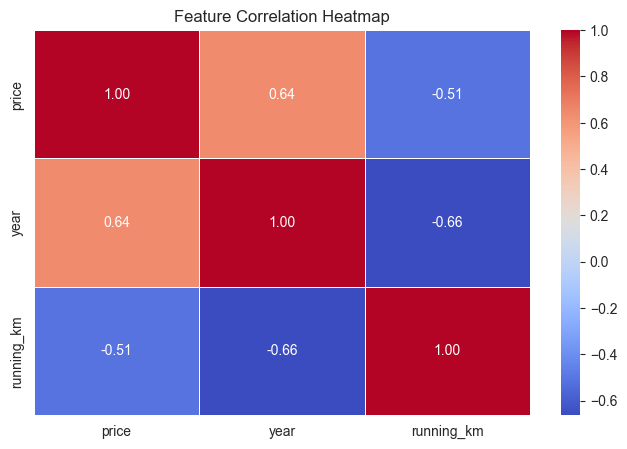

In [17]:
plt.figure(figsize=(8, 5))
sns.heatmap(trainData[selected_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

## Apply Cap outliers to the price

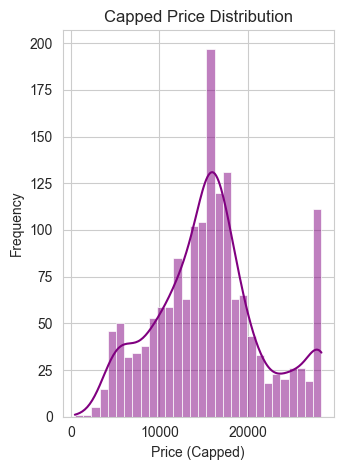

,price_capped
count,1642.000000
mean,15634.735688
std,6062.471053
min,462.000000
25%,12000.000000
50%,15750.000000
75%,18500.000000
max,28250.000000


In [18]:
# Identify Outliers using IQR method
Q1 = train_encoded["price"].quantile(0.25)
Q3 = train_encoded["price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_encoded["price_capped"] = np.where(train_encoded["price"] > upper_bound, upper_bound, train_encoded["price"])

# Capped Price Histogram
plt.subplot(1, 2, 2)
sns.histplot(train_encoded["price_capped"], bins=30, kde=True, color="purple")
plt.title("Capped Price Distribution")
plt.xlabel("Price (Capped)")
plt.ylabel("Frequency")

# Show Plots
plt.tight_layout()
plt.show()

train_encoded[["price_capped"]].describe()

# Model Training

## Feature Selection

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


X = train_encoded.drop(columns=["price", "price_capped"])
y = train_encoded["price_capped"]

# Training (80%), Testing (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Performance Comparison and Model selection

In [20]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Support Vector Regressor (SVR)": SVR()
}

results = {}

for model_name, model in models.items():

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    results[model_name] = [mae, mse, rmse, r2]

# Convert results to DataFrame and display
results_df = pd.DataFrame(results, index=["MAE", "MSE", "RMSE", "R² Score"]).T
print("Model Performance Comparison:\n")
print(results_df)


Model Performance Comparison:

                                        MAE           MSE         RMSE  \
Random Forest                   1902.349589  8.798545e+06  2966.234090   
Linear Regression               2304.151003  1.037675e+07  3221.295860   
Decision Tree                   2451.440729  1.479260e+07  3846.114547   
Support Vector Regressor (SVR)  4424.020386  3.453961e+07  5877.041089   

                                R² Score  
Random Forest                   0.751815  
Linear Regression               0.707297  
Decision Tree                   0.582737  
Support Vector Regressor (SVR)  0.025722  


##### Random Forest Regressor has outperformed the other models, achieved the lowest MAE (1902.35) and highest R² Score (0.7518). This confirms that Random Forest is the best model for car price prediction.

## Hyper parameter tuning for Random Forest

In [21]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }
#
# # Initialize the model
# rf = RandomForestRegressor(random_state=42)
#
# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )
#
# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)
#
# # Print best parameters
# print("Best Parameters:", grid_search.best_params_)
#
# # Train the model with the best parameters
# best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
# best_rf.fit(X_train, y_train)
#
# # Evaluate on test set
# y_pred = best_rf.predict(X_val)
#
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# mae = mean_absolute_error(y_val, y_pred)
# mse = mean_squared_error(y_val, y_pred)
# rmse = mse ** 0.5
# r2 = r2_score(y_val, y_pred)
#
# print(f"MAE: {mae}")
# print(f"MSE: {mse}")
# print(f"RMSE: {rmse}")
# print(f"R² Score: {r2}")


## Train and Save Random Forest Regressor

In [22]:
best_rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
best_rf.fit(X_train, y_train)

model_path = "model/random_forest_model.pkl"
joblib.dump(best_rf, model_path)
print(f"Model saved successfully as {model_path}")

Model saved successfully as model/random_forest_model.pkl


# Predict prices of test.csv

In [23]:
test_encoded = test_encoded[X.columns]

test_predictions = best_rf.predict(test_encoded)

submission_df = pd.DataFrame({"Id": testData["Id"], "Predicted Price": test_predictions})
submission_df["Predicted Price"] = submission_df["Predicted Price"].round().astype(int)

submission_path = "output/submission.csv"
submission_df.to_csv(submission_path, index=False)

print("Submission file generated at {}".format(submission_path))
submission_df

Submission file generated at output/submission.csv


,Id,Predicted Price
0,0,18079
1,1,16091
2,2,25210
3,3,14661
4,4,10007
...,...,...
406,406,23134
407,407,15379
408,408,15075
409,409,14403
